# Project 2: Topic Classification

Student: David Skarbrevik

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Ignore warnings for nicer looking final notebook
import warnings
warnings.filterwarnings('ignore')

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [28]:
categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


**Problem 1:**

For each of the first 5 training examples, print the text of the message along with the label.

In [15]:
def P1(num_examples=5):
    
    for i in range(num_examples):
        print("\n")
        print("**********************")
        print("Message Example #",i)
        print("**********************")

        print("\n", "Message Category = ", categories[train_labels[i]], 
              "\n\n", "----BEGIN MESSAGE TEXT---- ", "\n\n", 
              train_data[i], "\n\n", "----END MESSAGE TEXT----")
        
P1()



**********************
Message Example # 0
**********************

 Message Category =  talk.religion.misc 

 ----BEGIN MESSAGE TEXT----  

 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych 

 ----END MESSAGE TEXT----


**********************
Message Example # 1
**********************

 Message Category =  sci.space 

 ----BEGIN MESSAGE TEXT----  

 

Seems to be, barring evidence to the contrary, that Koresh was simply
another derang

***

**Problem 2:**

Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

Step 1: The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

Step 2: What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

Step 3: Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

Step 4: Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

Step 5: Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

Step 6: Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [16]:
def P2():

# Step 1: Size of vocab and num of non-zero features
    
    print("************************************************************")
    print("Step 1: Look at size of vocab and num of non-zero features")
    print("************************************************************")
    
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)

    print("The training data has a corpus of {} unique words.".format(X1.shape[1]))
    
    
    cumsum = 0 #counter for avg num non-zero features
    
    for i in range(X1.shape[0]):        
        cumsum += X1[i].nnz
    avg_nnz = cumsum / X1.shape[0]

    print("There are an average of {0:.2f} non-zero features per example.".format(avg_nnz))

    tot_pt_nnz = (X1.nnz/(X1.shape[0]*X1.shape[1]))*100
    
    print("{0:.2f}% of the entries in the sparse matrix are non-zero.".format(tot_pt_nnz))
                   
    
# Step 2: Finding specific feature strings

    print("\n")
    print("*********************************************")
    print("Step 2: Finding specific feature strings")
    print("*********************************************")
    
    print("The alphabetically first word feature is \"{}\"".format(vectorizer1.get_feature_names()[0]))
    print("The alphabetically last word feature is \"{}\""
          .format(vectorizer1.get_feature_names()[len(vectorizer1.get_feature_names())-1]))        
            

# Step 3: custom vocabulary for fitting
    
    print("\n")
    print("****************************************")
    print("Step 3: custom vocabulary for fitting")
    print("****************************************")
          
    myVocab = ["atheism", "graphics", "space", "religion"] #custom vocabulary
    
    vectorizer2 = CountVectorizer(min_df=1)
    Y = vectorizer2.fit(myVocab) 
    Y = Y.transform(train_data) #transform the sparse matrix with train data

    cumsum = 0 #counter for avg num non-zero features

    for i in range(Y.shape[0]):        
        cumsum += Y[i].nnz
    avg_nnz = cumsum / Y.shape[0]

    print("There are an average of {0:.2f} non-zero features per example.".format(avg_nnz))
    
    
# Step 4: birgram/trigram character vocabulary
     
    print("\n")
    print("*********************************************")
    print("Step 4: birgram/trigram character vocabulary")
    print("*********************************************")
      
    bigram_vectorizer = CountVectorizer(analyzer = "char", ngram_range=(1,2))
    X2 = bigram_vectorizer.fit_transform(train_data)
    
    print("The training data has a bigram corpus of {} unique characters.".format(X2.shape[1]))
    
    trigram_vectorizer = CountVectorizer(analyzer = "char", ngram_range=(1,3))
    X3 = trigram_vectorizer.fit_transform(train_data)
    
    print("The training data has a trigram corpus of {} unique characters.".format(X3.shape[1]))
    
# Step 5 : prune words occurring less than 10 times   
    
    print("\n")         
    print("**************************************************")
    print("Step 5 : prune words occurring less than 10 times")
    print("**************************************************")     
          
    vectorizer3 = CountVectorizer(min_df=10)
    X4 = vectorizer3.fit_transform(train_data)
    
    print("With a 10 word min. occurrance cut off, the training data corpus has {} unique words.".format(X4.shape[1]))
    print("That is {0:.0f}% fewer words than if the corpus had no cut-off limit."
          .format((X1.shape[1]/(X1.shape[1]+X4.shape[1]))*100))
    
# Step 6: get fraction of words in dev data missing from train data

    print("\n")          
    print("*****************************************************************")
    print("Step 6: get fraction of words in dev data missing from train data")
    print("*****************************************************************") 
          
    vectorizer4 = CountVectorizer()
    X5 = vectorizer4.fit_transform(dev_data)
    
    missing_words = list(set(vectorizer4.get_feature_names()) - set(vectorizer1.get_feature_names()))
    
    print("There are {} words in the dev data that are not in the train data.".format(len(missing_words)))
    
P2()

************************************************************
Step 1: Look at size of vocab and num of non-zero features
************************************************************
The training data has a corpus of 26879 unique words.
There are an average of 96.71 non-zero features per example.
0.36% of the entries in the sparse matrix are non-zero.


*********************************************
Step 2: Finding specific feature strings
*********************************************
The alphabetically first word feature is "00"
The alphabetically last word feature is "zyxel"


****************************************
Step 3: custom vocabulary for fitting
****************************************
There are an average of 0.27 non-zero features per example.


*********************************************
Step 4: birgram/trigram character vocabulary
*********************************************
The training data has a bigram corpus of 3370 unique characters.
The training data has a trigram c

**Problem 2 Answer/Analysis:**

We see that few of the entries in the sparse matrix are non-zero as expected since our dictionary is very large. 

In our custom dictionary we see a low per example non-zero feature rate but that also makes sense given our dictionary is only a few words. It is unlikely that those exact words appear in many examples since they are not very common words like "as", "the", "it". 

In step 5, we see the expected results that increasing the minimum occurance cut-off for words decreases the amount of words in the final corpus.

In step 6, we see that about a third of the words in our dev data are not in our training data, this doesn't seem particularly strange but highlights the idea that even though our current corpus/vocabular seems large, we are likely missing many many more words.

***

**Problem 3**

Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [21]:
def P3():
    
    # First vectorize our train_data and dev_data 
    
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)  
        
    vectorizer2 = CountVectorizer()
    X2 = vectorizer2.fit(train_data)
    X2 = X2.transform(dev_data)

    # Try fitting a k-nn model

    k_values = {"n_neighbors":list(range(1,10))} # for GridSearchCV to find best k value   
    model1 = KNeighborsClassifier()
    kneighbor_model = GridSearchCV(model1, k_values, scoring="f1_macro")
    kneighbor_model.fit(X1, train_labels)
    f1score = kneighbor_model.score(X2, dev_labels) 
   
    print("\n")
    print("F1 score for {}-Nearest Neighbors Model = {:.2f}".format(kneighbor_model.best_params_["n_neighbors"],f1score))
    print("\n")

    # Try fitting a multinomial naive bayes model
    
    alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    model2 = MultinomialNB()
    multinomial_model = GridSearchCV(model2, alphas, scoring="f1_macro")
    multinomial_model.fit(X1, train_labels)
    f1score = multinomial_model.score(X2, dev_labels) 
    multinomial_model.best_params_["alpha"]
    
    print("\n")
    print("F1 score for a Multinomial Naive Bayes Model (w/ an alpha of {}) = {:.2f}".format(multinomial_model.best_params_["alpha"],f1score))
    print("\n")

    
    # Try fitting a logistic regression model
    C_vals = {'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    model3 = LogisticRegression()
    regression_model = GridSearchCV(model3, C_vals, scoring="f1_macro")
    regression_model.fit(X1, train_labels)
    regression_model.best_params_
    f1score = regression_model.score(X2, dev_labels)
    regression_model.get_params    
    print("\n")
    print("F1 score for a Logistic Regression Model ( w/ a reg. strength C of {}) = {:.2f}"
          .format(regression_model.best_params_["C"],f1score))
    print("\n")
    
    C_vals = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for i in C_vals:
        model3 = LogisticRegression(C=i)
        model3.fit(X1, train_labels)
        print("------------------------------------------------------------")
        for j in range(4):
            print("Sum of squared weights for label = {} and C = {} is {:.2f}"
                  .format(categories[j], i, np.sum(np.square(model3.coef_[j]))))
        print("------------------------------------------------------------")
        
P3()



F1 score for 9-Nearest Neighbors Model = 0.42




F1 score for a Multinomial Naive Bayes Model (w/ an alpha of 0.01) = 0.76




F1 score for a Logistic Regression Model ( w/ a reg. strength C of 0.5) = 0.69


------------------------------------------------------------
Sum of squared weights for label = alt.atheism and C = 0.001 is 0.17
Sum of squared weights for label = talk.religion.misc and C = 0.001 is 0.20
Sum of squared weights for label = comp.graphics and C = 0.001 is 0.18
Sum of squared weights for label = sci.space and C = 0.001 is 0.19
------------------------------------------------------------
------------------------------------------------------------
Sum of squared weights for label = alt.atheism and C = 0.01 is 2.54
Sum of squared weights for label = talk.religion.misc and C = 0.01 is 2.94
Sum of squared weights for label = comp.graphics and C = 0.01 is 2.86
Sum of squared weights for label = sci.space and C = 0.01 is 2.25
--------------------------------------------

**Problem 3 Answer/Analysis:**

a)
K-nearest neighbors does not work well for this problem because it has very high dimensionality. There are many features and they may not be very close together. 

b)
For the idea of NB vs. Log Regression, it seems that the independence assumption of NB may be giving an advantage to generality of model at this data size. Perhaps if we had significantly more documents to work with log regression once come out ahead.

c)
We can see that as the strength of the regularization term decreases (higher values of C), the sum of squared weights for each label increases. That is, as the strength of regularization is decreased, terms like "the", "and", "is", etc. are given more weight than when regularization is more strict.
***


**Problem 4:**

Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

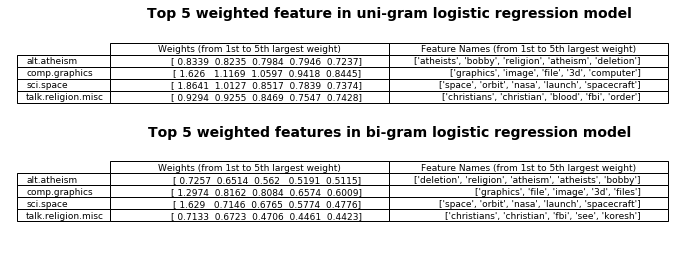

In [29]:
def P4():
    
    # First vectorize our train_data and dev_data 
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)  
    
    # Next a vectorizer for bigrams
    vectorizer2 = CountVectorizer(ngram_range=(1,2))
    X2 = vectorizer2.fit_transform(train_data) 
    
    # Use most optimized C reg. term
    C_val = 0.5

    # Simple logistic regression model
    regression_model1 = LogisticRegression(C=C_val)
    regression_model1.fit(X1, train_labels)
    
    # Bigram logistic regression model
    regression_model2 = LogisticRegression(C=C_val)
    regression_model2.fit(X2, train_labels)
  
    # Used for getting lists of 5 largest weight features for unigram and bigram models
    large_weights_uni = [] 
    large_weights_bi = [] 
    large_name_uni = []
    large_name_bi = []
    tmp1 = []
    tmp2 = []
    
    # The weights
    for i in range(4):
        weights_uni = np.sort(regression_model1.coef_[i])[::-1]
        weights_bi = np.sort(regression_model2.coef_[i])[::-1]
        large_weights_uni.append(weights_uni[:5])
        large_weights_bi.append(weights_bi[:5])
        
    # The feature name (word)   
    for i in range (4):
        for j in range(5):
            key = int(np.where(regression_model1.coef_ == large_weights_uni[i][j])[1])
            tmp1.append(vectorizer1.get_feature_names()[key])
            key = int(np.where(regression_model2.coef_ == large_weights_bi[i][j])[1])
            tmp2.append(vectorizer2.get_feature_names()[key])            
        large_name_uni.append(tmp1)
        large_name_bi.append(tmp2)
        tmp1 = []
        tmp2 = []
    
    # Clean decimal place for plotting
    large_weights_uni = np.round(large_weights_uni, decimals=4)
    large_weights_bi = np.round(large_weights_bi, decimals=4)
    
    # Draw tables for the data
    
    colnames = ["Weights (from 1st to 5th largest weight)", 
    "Feature Names (from 1st to 5th largest weight)"]
    
    fig, axs =plt.subplots(2,1, figsize=(10,4))
    
    axs[0].axis('tight')
    axs[0].axis('off')
    axs[0].set_title("Top 5 weighted feature in uni-gram logistic regression model",
                       fontsize=14, fontweight="bold")
    axs[1].axis('tight')
    axs[1].axis('off')
    axs[1].set_title("Top 5 weighted features in bi-gram logistic regression model",
                       fontsize=14, fontweight="bold")
    
    the_table1 = axs[0].table(cellText=list(zip(large_weights_uni,large_name_uni)),
                          rowLabels=categories,
                          colLabels=colnames,
                          loc="center")
    
    the_table1 = axs[1].table(cellText=list(zip(large_weights_bi,large_name_bi)),
                          rowLabels=categories,
                          colLabels=colnames,
                          loc="center")   
    
    plt.show()

P4()

**Problem 4 Answer/Analysis:**

The label "alt.atheism" strangely has the word "bobby" weighted very heavily on both the uni-gram and bi-gram logestic regressions. Also the label "talk.religion.misc" strangely has the word fbi weighted heavily in both regression models as well.

***

**Problem 5**

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [24]:
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    lower_string = [x.lower() for x in s]
    return lower_string
  
def P5():

    processed_data = better_preprocessor(train_data)
    
    # With no pre-processing
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)
    
    # With pre-processing
    vectorizer2 = CountVectorizer()
    X2 = vectorizer2.fit_transform(processed_data)
    
    # Vectorize the dev data for scoring our logistic regression models
    vectorizer3 = CountVectorizer()
    Y1 = vectorizer3.fit(train_data)
    Y1 = vectorizer3.transform(dev_data)
        
    # Use most optimized C reg. term
    C_val = 0.5
    
    # Logistic regression without pre-processing
    regression_model1 = LogisticRegression(C=C_val)
    regression_model1.fit(X1, train_labels)
    preds1 = regression_model1.predict(Y1)
    score1 = metrics.f1_score(dev_labels, preds1, average="macro")
    print("F1 score for log. regression w/o pre-processing = {:.4f}".format(score1))
    
    # Logistic regression with pre-processing
    regression_model2 = LogisticRegression(C=C_val)
    regression_model2.fit(X2, train_labels)    
    preds2 = regression_model2.predict(Y1)    
    score2 = metrics.f1_score(dev_labels, preds2, average="macro")    
    print("F1 score for log. regression w/ pre-processing = {:.4f}".format(score2))    

P5()


F1 score for log. regression w/o pre-processing = 0.6920
F1 score for log. regression w/ pre-processing = 0.6920


**Problem 5 Answer/Analysis:**

I saw that simply preprocessing by making all documents in lowercase does not change the F1 score at all. This was a little surprising but not that surprising as that doesn't seem like it would provide a significant improvement to the model in any way.

***

**Problem 6**

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

F1 score for log. regression with C=0.5 and L2 regularization = 0.6920
F1 score for log. regression with C=0.5 and L1 regularization = 0.6732
L2 regularization gives 0 weights that are equal to 0, while L1 regularization gives 106345 weights that are equal to 0.


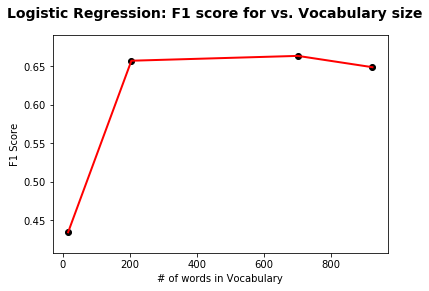

In [26]:
def P6():
    
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
   
    # Regularization strength term for upcoming log. reg. models
    c_vals = [0.01, 0.1, 0.5, 0.9]
    
    # First vectorize the train data
    vectorizer1 = CountVectorizer()
    X1 = vectorizer1.fit_transform(train_data)
    
    # Next vectorize the dev data for prediction
    vectorizer2 = CountVectorizer()
    Y1 = vectorizer2.fit(train_data)
    Y1 = vectorizer2.transform(dev_data)
    
    # L2 regularization
    regression_model1 = LogisticRegression(C=c_vals[2])
    regression_model1.fit(X1, train_labels)
    preds1 = regression_model1.predict(Y1)
    score1 = metrics.f1_score(dev_labels, preds1, average="macro")
    print("F1 score for log. regression with C=0.5 and L2 regularization = {:.4f}".format(score1))
    
    # Look at num of zero valued weights
    L2_zeros = np.sum(regression_model1.coef_ == 0.)
    
    #L1 regularization
    regression_model2 = LogisticRegression(penalty="l1", C=0.5)
    regression_model2.fit(X1, train_labels)
    preds2 = regression_model2.predict(Y1)
    score2 = metrics.f1_score(dev_labels, preds2, average="macro")
    print("F1 score for log. regression with C=0.5 and L1 regularization = {:.4f}".format(score2))
    
    # Look at num of zero valued weights   
    L1_zeros = np.sum(regression_model2.coef_ == 0.)
    
    print("L2 regularization gives {} weights that are equal to 0, while L1 regularization gives {} weights that are equal to 0."
          .format(L2_zeros,L1_zeros))
    
    # Some models to get a smaller vocabulary with non-zero features for a few L1 reg. values 
    regression_model3 = LogisticRegression(penalty="l1", C=c_vals[0])
    regression_model3.fit(X1, train_labels)
    
    regression_model4 = LogisticRegression(penalty="l1", C=c_vals[1])
    regression_model4.fit(X1, train_labels)
    
    regression_model5 = LogisticRegression(penalty="l1", C=c_vals[3])
    regression_model5.fit(X1, train_labels)
    
    # for extracting vocab at each C value
    all_models = [regression_model3.coef_, regression_model4.coef_, regression_model2.coef_, regression_model5.coef_]
    cut_down_vocab_part = []
    cut_down_vocab_comp = []
    temp = []
    
    for curr_model in all_models:
        for j in range(4):
            for k in range(26879):
                if (curr_model[j,k] != 0):
                    temp += [k]
            cut_down_vocab_part += list(set(temp) - set(cut_down_vocab_part))
            temp = []
        cut_down_vocab_comp.append(cut_down_vocab_part)
        cut_down_vocab_part = []

        
    # Get all the original vocab words 
    small_vocab = []
    small_vocab_comp = []
    X2 = vectorizer2.fit(train_data)    
    total_vocab = list(X2.get_feature_names())
    for i in range(4):
        for j in cut_down_vocab_comp[i]:
            small_vocab.append(total_vocab[j])
        small_vocab_comp.append(small_vocab)
        small_vocab = []

    # Get all f-scores
    f1_scores = []
    for i in range(4):
        # Vectorize the new small vocab list
        vectorizer3 = CountVectorizer()
        X2_small = vectorizer3.fit(small_vocab_comp[i])
        X2_small = vectorizer3.transform(train_data)
        
        # Vectorize the dev data on new vocab
        vectorizer4 = CountVectorizer()
        Y2_small = vectorizer3.fit(small_vocab_comp[i])
        Y2_small = vectorizer3.transform(dev_data)
        
        # New log. model with small vocab
        regression_model3 = LogisticRegression(C=c_vals[i])
        regression_model3.fit(X2_small, train_labels)
        preds3 = regression_model3.predict(Y2_small)
        
        f1_scores.append(metrics.f1_score(dev_labels, preds3, average="macro"))
    
    # Make list of vocab sizes to plot in next step
    vocab_size = []
    for i in range(4):
        vocab_size.append(len(small_vocab_comp[i]))
    
    # Plot F1 score vs. Vocab Size for Logistic Regression
    fig = plt.figure()
    fig.suptitle("Logistic Regression: F1 score for vs. Vocabulary size", fontsize=14, fontweight="bold")
    plt.ylabel("F1 Score")
    plt.xlabel("# of words in Vocabulary")
    plt.scatter(vocab_size, f1_scores, color="black") 
    plt.plot(vocab_size, f1_scores, color="red", linewidth=2)
    plt.show()
    
P6() 

**Problem 6 Answer/Analysis:**

We see that L2 regularization results in a higher F1 score. Speaking informally, I found several comments online stating that while theoretically there may be times when L1 regularization may seem more appropriate, in practice these cases are essentially non-existant (everyone uses L2 for regularization).

From the four C values chosen we see that a C of 0.5 still gives the highest F1-score as in a previous problem's GridSearchCV choice. Also worth mentioning, having a very small vocabulary is remarkably bad for our F1 score.
***

**Problem 7**

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [30]:
def P7():

    vectorizer1 = TfidfVectorizer()
    X1 = vectorizer1.fit_transform(train_data)
    
    vectorizer2 = TfidfVectorizer()
    Y1 = vectorizer2.fit(train_data)
    Y1 = vectorizer2.transform(dev_data)

    regression_model1 = LogisticRegression(C=100)
    regression_model1.fit(X1, train_labels)
   
    # Calculate R-ratio for dev data
    prob = regression_model1.predict_proba(Y1)
    preds = regression_model1.predict(Y1)
    R_vals = []

    for i in range(prob.shape[0]):
        R_vals.append(max(prob[i])/prob[i][dev_labels[i]])
    R_vals_highest = (np.sort(R_vals)[::-1])[:5]

    
    # Put the Highest R_val Messages in an array
    hard_messages = []
    hard_messages_indices = []
    for i in range(len(R_vals_highest)):
        key = int(np.where(R_vals == R_vals_highest[i])[0])
        hard_messages.append(dev_data[key])
        hard_messages_indices.append(key)



    hard_messages_pred_label = preds[hard_messages_indices]
    hard_messages_true_label = dev_labels[hard_messages_indices]
    



    for i in range(len(hard_messages)):
        print("\n")
        print("***************************")
        print("#{} Most Mis-Matched Message".format(i+1))
        print("***************************")
        print("\n")
        print("Logistic Regression thought the label was: \"{}\" ".format(categories[hard_messages_pred_label[i]]))
        print("The actual label was: \"{}\"".format(categories[hard_messages_true_label[i]]))
        print("\n\n", "----BEGIN MESSAGE TEXT---- ", "\n\n", 
              hard_messages[i], "\n\n", "----END MESSAGE TEXT----")
 
P7()



***************************
#1 Most Mis-Matched Message
***************************


Logistic Regression thought the label was: "comp.graphics" 
The actual label was: "talk.religion.misc"


 ----BEGIN MESSAGE TEXT----  

 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (p

**Problem 7 Answer/Analysis:**

The TfidfVectorizer works by giving weights to each feature based on how common its occurance across labels is instead of just on raw count values. That is, if a word occurs frequently in EVERY label it will not be weighted as heavily as a word that occurs frequently in one specific label.

This method seems to make it hard to differentiate between words that occur often in just two labels. Because these words aren't in all labels, they are likely weighted heavily but this just makes it harder for the two labels that do have them to be destinguished. Perhaps a simple answer is to consider multi-gram models to help provide distinction when two labels have similar frequently used words.

***

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.